In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset,TensorDataset
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as tt
import json
import re
import string
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import Vocab
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence

# importing torch.optim and torch.nn.functional
import torch.optim as optim
from sklearn import datasets
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
#from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

print(torch.__version__)
print(torchvision.__version__)

# Create a SummaryWriter
writer = SummaryWriter()

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
device

2.0.1
0.15.1


device(type='mps')

In [2]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [4]:
# import MNIST dataset

from torchvision import datasets

# Loading x_train and x_test from MNIST
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


    4     6     4     0     2     7     6     1


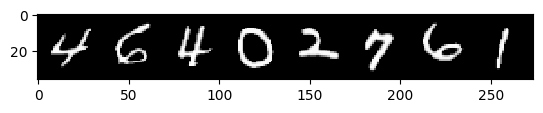

In [4]:
# Display some images
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
show(torchvision.utils.make_grid(images[:8]))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(8)))


In [5]:
# checking the range of the pixel values
img = images[0]
print(img.shape)
print(img.min())
print(img.max())


torch.Size([1, 32, 32])
tensor(-1.)
tensor(0.9922)


In [54]:
from PIL import Image

# import random
# import torch

import random

def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
    inp_imgs = inp_imgs.float()
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += torch.randn_like(inp_imgs) * noise
        inp_imgs = torch.clamp(inp_imgs, -1.0, 1.0)
        inp_imgs = inp_imgs.float()
        with torch.enable_grad():
            inp_imgs.requires_grad = True
            out_score = model(inp_imgs)
        grads = torch.autograd.grad(out_score.sum(), inp_imgs)[0]
        grads = torch.clamp(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = torch.clamp(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs.clone())
    if return_img_per_step:
        return torch.stack(imgs_per_step, dim=0)
    else:
        return inp_imgs.float()


class ImageGenerator:
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, model, writer):
        model.eval()
        start_imgs = (
            torch.FloatTensor(np.random.uniform(size=(self.num_img, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)))
            * 2
            - 1
        ).to(next(model.parameters()).device)

        generated_images = generate_samples(
            model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.cpu().detach().numpy()
        # Save generated images as PNG files
        for i, img in enumerate(generated_images):
            save_path = f"/Users/parkermoesta/Generative_models/Generative_models/Energy Based Models/imgs_{epoch:03d}_{i:02d}.png"
            # Convert NumPy array to PIL Image
            pil_image = Image.fromarray(np.uint8((img + 1) * 0.5 * 255))

            # Save the image
            pil_image.save(save_path)

        # Log generated images to TensorBoard
        grid_images = torch.FloatTensor(generated_images).unsqueeze(1)
        writer.add_images("Generated Images", grid_images, epoch)

        example_images = torch.cat(
            random.choices(model.buffer.examples, k=10), dim=0
        ).cpu().detach().numpy()
        # Save example images as PNG files
        for i, img in enumerate(example_images):
            save_path = f"/Users/parkermoesta/Generative_models/Generative_models/Energy Based Models/imgs_{epoch:03d}_{i:02d}.png"
            # Convert NumPy array to PIL Image
            pil_image = Image.fromarray(np.uint8((img + 1) * 0.5 * 255))

            # Save the image
            pil_image.save(save_path)

        # Log example images to TensorBoard
        grid_images = torch.FloatTensor(example_images).unsqueeze(1)
        writer.add_images("Example Images", grid_images, epoch)

In [55]:

class EBM(nn.Module):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(CHANNELS, 16, kernel_size=5, stride=2, padding=2),
            nn.SiLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.SiLU(),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.SiLU(),
            nn.Linear(64, 1)
        )
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = AverageMeter()
        self.reg_loss_metric = AverageMeter()
        self.cdiv_loss_metric = AverageMeter()
        self.real_out_metric = AverageMeter()
        self.fake_out_metric = AverageMeter()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)

    def forward(self, x):
        x = x.float()
        return self.model(x)


class Buffer:
    def __init__(self, model):
        self.model = model
        self.examples = [
            torch.randn((1, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)) * 2 - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (torch.rand((n_new, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)) * 2 - 1)
        old_imgs = torch.cat([random.choice(self.examples) for _ in range(BATCH_SIZE - n_new)], dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0)
        inp_imgs = inp_imgs.float()
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = torch.split(inp_imgs, 1, dim=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs



class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0.0
        self.avg = 0.0
        self.sum = 0.0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [56]:
def train_model(model, train_loader, test_loader, device):
    writer = SummaryWriter(log_dir="./logs")
    image_generator_callback = ImageGenerator(num_img=10)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    model.to(device)

    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        train_loss_meter = AverageMeter()

        for batch_idx, real_imgs in enumerate(train_loader):
            real_imgs = real_imgs.to(device)

            optimizer.zero_grad()

            output = model.train_step(real_imgs)

            train_loss_meter.update(output['loss'])

            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch}/{EPOCHS}], "
                    f"Batch [{batch_idx}/{len(train_loader)}], "
                    f"Loss: {train_loss_meter.avg:.4f}"
                )

        model.eval()
        test_loss_meter = AverageMeter()

        with torch.no_grad():
            for real_imgs in test_loader:
                real_imgs = real_imgs.to(device)
                output = model.test_step(real_imgs)
                test_loss_meter.update(output['cdiv_loss'])

        print(
            f"Epoch [{epoch}/{EPOCHS}], "
            f"Train Loss: {train_loss_meter.avg:.4f}, "
            f"Test Loss: {test_loss_meter.avg:.4f}"
        )

        writer.add_scalar("Train Loss", train_loss_meter.avg, epoch)
        writer.add_scalar("Test Loss", test_loss_meter.avg, epoch)

        image_generator_callback.on_epoch_end(epoch, model, writer)

        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"model_{epoch}.pt")

    writer.close()

In [57]:
train_loader

In [58]:
print(type(train_loader))
print(type(test_loader))

<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [59]:
print(train_loader.dataset)
print(test_loader.dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [60]:
# check the shape of first batch of train loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape), print(labels.shape)


torch.Size([128, 1, 32, 32])
torch.Size([128])


(None, None)

In [61]:
def contrastive_divergence_loss(model, real_imgs, negative_samples):
    real_imgs_energy = model(real_imgs).mean()
    negative_samples_energy = model(negative_samples).mean()
    loss = real_imgs_energy - negative_samples_energy
    return loss

In [62]:
model = EBM().to(device)

# putting train and test loader on device
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)


def train_model(model, train_loader, test_loader, device):
    writer = SummaryWriter(log_dir="./logs")
    image_generator_callback = ImageGenerator(num_img=10)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    model.to(device)

    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        train_loss_meter = AverageMeter()

        for batch_idx, (real_imgs, _) in enumerate(train_loader):
            real_imgs = real_imgs.float().to(device)

            # Generate negative samples
            negative_samples = model.buffer.sample_new_exmps(STEPS, STEP_SIZE, NOISE).float()
            negative_samples = negative_samples.float().to(device)

            optimizer.zero_grad()

            # Compute loss
            loss = contrastive_divergence_loss(model, real_imgs, negative_samples)

            # Backpropagation
            loss.backward()
            optimizer.step()

            train_loss_meter.update(loss.item())

            if batch_idx % 100 == 0:
                print(
                    f"Epoch [{epoch}/{EPOCHS}], "
                    f"Batch [{batch_idx}/{len(train_loader)}], "
                    f"Loss: {train_loss_meter.avg:.4f}"
                )

        model.eval()
        test_loss_meter = AverageMeter()

        with torch.no_grad():
            for real_imgs in test_loader:
                real_imgs = real_imgs.to(device)
                output = model.test_step(real_imgs)
                test_loss_meter.update(output['cdiv_loss'])

        print(
            f"Epoch [{epoch}/{EPOCHS}], "
            f"Train Loss: {train_loss_meter.avg:.4f}, "
            f"Test Loss: {test_loss_meter.avg:.4f}"
        )

        writer.add_scalar("Train Loss", train_loss_meter.avg, epoch)
        writer.add_scalar("Test Loss", test_loss_meter.avg, epoch)

        image_generator_callback.on_epoch_end(epoch, model, writer)

        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"model_{epoch}.pt")

    writer.close()


model = EBM().to(device)
train_model(model, train_loader, test_loader, device)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:01<?, ?it/s]


RuntimeError: Mismatched Tensor types in NNPack convolutionOutput

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import random

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 64
BUFFER_SIZE = 10000
IMAGE_SIZE = 28
CHANNELS = 1
STEPS = 20
STEP_SIZE = 0.1
NOISE = 0.1
ALPHA = 0.1
GRADIENT_CLIP = 1.0
# Function to generate samples using Langevin Dynamics

def generate_samples(model, inp_imgs, steps, step_size, noise, return_img_per_step=False):
    inp_imgs = inp_imgs.float()
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += torch.randn_like(inp_imgs) * noise
        inp_imgs = torch.clamp(inp_imgs, -1.0, 1.0)
        inp_imgs = inp_imgs.float()
        with torch.enable_grad():
            inp_imgs.requires_grad = True
            out_score = model(inp_imgs)
        grads = torch.autograd.grad(out_score.sum(), inp_imgs)[0]
        grads = torch.clamp(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = torch.clamp(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs.clone())
    if return_img_per_step:
        return torch.stack(imgs_per_step, dim=0)
    else:
        return inp_imgs.float()

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, IMAGE_SIZE * IMAGE_SIZE * CHANNELS)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        x = x.view(-1, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return x

# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(CHANNELS, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.fc1 = nn.Linear(128 * 7 * 7, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = x.view(-1, 128 * 7 * 7)
        x = self.fc1(x)
        return x

# Define the buffer
class Buffer:
    def __init__(self, generator):
        super().__init__()
        self.generator = generator
        self.examples = [
            torch.rand(1, CHANNELS, IMAGE_SIZE, IMAGE_SIZE) * 2 - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = torch.rand(n_new, CHANNELS, IMAGE_SIZE, IMAGE_SIZE) * 2 - 1
        old_imgs = torch.cat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), dim=0
        )
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0)
        inp_imgs = generate_samples(
            self.generator, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = torch.split(inp_imgs, BATCH_SIZE, dim=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

# Define the energy-based model
class EBM(nn.Module):
    def __init__(self, generator, discriminator):
        super(EBM, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.buffer = Buffer(self.generator)
        self.alpha = ALPHA

    def forward(self, x):
        return self.discriminator(x)

    def train_step(self, real_imgs):
        real_imgs += torch.randn_like(real_imgs) * NOISE
        real_imgs = torch.clamp(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = torch.split(self.discriminator(inp_imgs), 2, dim=0)
        cdiv_loss = torch.mean(fake_out, dim=0) - torch.mean(real_out, dim=0)
        reg_loss = self.alpha * torch.mean(real_out**2 + fake_out**2, dim=0)
        loss = cdiv_loss + reg_loss
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.discriminator.parameters(), GRADIENT_CLIP)
        self.optimizer.step()
        return loss.item()

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = torch.rand(batch_size, CHANNELS, IMAGE_SIZE, IMAGE_SIZE) * 2 - 1
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = torch.split(self.discriminator(inp_imgs), 2, dim=0)
        cdiv = torch.mean(fake_out, dim=0) - torch.mean(real_out, dim=0)
        return cdiv.item()

# Define the data loaders
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize the models and optimizer
generator = Generator().to(device)
discriminator = Discriminator().to(device)
ebm = EBM(generator, discriminator).to(device)
ebm.optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Train the model
num_epochs = 60
for epoch in range(num_epochs):
    for i, (real_imgs, _) in enumerate(trainloader):
        real_imgs = real_imgs.to(device)
        loss = ebm.train_step(real_imgs)
        if i % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], Loss: {loss:.4f}"
            )
    cdiv = ebm.test_step(real_imgs)
    print(f"Epoch [{epoch+1}/{num_epochs}], CDIV: {cdiv:.4f}")
    with torch.no_grad():
        fake_imgs = generator(torch.randn(10, 100).to(device)).cpu()
        save_image(fake_imgs, f"./output/generated_img_{epoch+1:03d}.png")
        example_imgs = torch.cat(
            random.choices(ebm.buffer.examples, k=10), dim=0
        ).cpu()
        save_image(example_imgs, f"./output/example_img_{epoch+1:03d}.png")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1792x28 and 100x128)

## Model V2

In [66]:
# install pytorch lightning
!pip install pytorch_lightning

In [12]:
# uninstall pytorch lightning
!pip uninstall pytorch_lightning -y

Found existing installation: pytorch-lightning 2.0.1.post0
Uninstalling pytorch-lightning-2.0.1.post0:
  Successfully uninstalled pytorch-lightning-2.0.1.post0


In [3]:
# Standard libraries
import os
import json
import math
import numpy as np
import random

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
#import lightning as L
import pytorch_lightning as pl

#from lightning.callbacks import LearningRateMonitor, ModelCheckpoint


from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

/var/folders/l0/978kqtls1gb5jnv3rvxtjpvh0000gn/T/ipykernel_95959/124085359.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [13]:
# import MNIST dataset

from torchvision import datasets

# Loading x_train and x_test from MNIST
transform = transforms.Compose([
   # transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [14]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [15]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs) # Minus sign because we want to maximize the output
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

In [16]:
class DeepEnergyModel(pl.LightningModule):

    def __init__(self, img_shape, batch_size, alpha=0.1, lr=1e-4, beta1=0.0, **CNN_args):
        super().__init__()
        self.save_hyperparameters()

        self.cnn = CNNModel(**CNN_args)
        self.sampler = Sampler(self.cnn, img_shape=img_shape, sample_size=batch_size)
        self.example_input_array = torch.zeros(1, *img_shape)

    def forward(self, x):
        z = self.cnn(x)
        return z

    def configure_optimizers(self):
        # Energy models can have issues with momentum as the loss surfaces changes with its parameters.
        # Hence, we set it to 0 by default.
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr, betas=(self.hparams.beta1, 0.999))
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.97) # Exponential decay over epochs
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # We add minimal noise to the original images to prevent the model from focusing on purely "clean" inputs
        real_imgs, _ = batch
        small_noise = torch.randn_like(real_imgs) * 0.005
        real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)

        # Obtain samples
        fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)

        # Predict energy score for all images
        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        # Calculate losses
        reg_loss = self.hparams.alpha * (real_out ** 2 + fake_out ** 2).mean()
        cdiv_loss = fake_out.mean() - real_out.mean()
        loss = reg_loss + cdiv_loss

        # Logging
        self.log('loss', loss)
        self.log('loss_regularization', reg_loss)
        self.log('loss_contrastive_divergence', cdiv_loss)
        self.log('metrics_avg_real', real_out.mean())
        self.log('metrics_avg_fake', fake_out.mean())
        return loss

    def validation_step(self, batch, batch_idx):
        # For validating, we calculate the contrastive divergence between purely random images and unseen examples
        # Note that the validation/test step of energy-based models depends on what we are interested in the model
        real_imgs, _ = batch
        fake_imgs = torch.rand_like(real_imgs) * 2 - 1

        inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

        cdiv = fake_out.mean() - real_out.mean()
        self.log('val_contrastive_divergence', cdiv)
        self.log('val_fake_out', fake_out.mean())
        self.log('val_real_out', real_out.mean())

In [17]:
class GenerateCallback(pl.Callback):

    def __init__(self, batch_size=8, vis_steps=8, num_steps=256, every_n_epochs=5):
        super().__init__()
        self.batch_size = batch_size         # Number of images to generate
        self.vis_steps = vis_steps           # Number of steps within generation to visualize
        self.num_steps = num_steps           # Number of steps to take during generation
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        # Skip for all other epochs
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Generate images
            imgs_per_step = self.generate_imgs(pl_module)
            # Plot and add to tensorboard
            for i in range(imgs_per_step.shape[1]):
                step_size = self.num_steps // self.vis_steps
                imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
                grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1))
                trainer.logger.experiment.add_image(f"generation_{i}", grid, global_step=trainer.current_epoch)

    def generate_imgs(self, pl_module):
        pl_module.eval()
        start_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
        start_imgs = start_imgs * 2 - 1
        torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary
        imgs_per_step = Sampler.generate_samples(pl_module.cnn, start_imgs, steps=self.num_steps, step_size=10, return_img_per_step=True)
        torch.set_grad_enabled(False)
        pl_module.train()
        return imgs_per_step

In [18]:
class SamplerCallback(pl.Callback):

    def __init__(self, num_imgs=32, every_n_epochs=5):
        super().__init__()
        self.num_imgs = num_imgs             # Number of images to plot
        self.every_n_epochs = every_n_epochs # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            exmp_imgs = torch.cat(random.choices(pl_module.sampler.examples, k=self.num_imgs), dim=0)
            grid = torchvision.utils.make_grid(exmp_imgs, nrow=4, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("sampler", grid, global_step=trainer.current_epoch)

In [19]:
class OutlierCallback(pl.Callback):

    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size

    def on_epoch_end(self, trainer, pl_module):
        with torch.no_grad():
            pl_module.eval()
            rand_imgs = torch.rand((self.batch_size,) + pl_module.hparams["img_shape"]).to(pl_module.device)
            rand_imgs = rand_imgs * 2 - 1.0
            rand_out = pl_module.cnn(rand_imgs).mean()
            pl_module.train()

        trainer.logger.experiment.add_scalar("rand_out", rand_out, global_step=trainer.current_epoch)

In [22]:
CHECKPOINT_PATH = '/Users/parkermoesta/Generative_models/Generative_models/Energy Based Models/models'

def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "MNIST"),
                         accelerator="gpu" if str(device).startswith("cuda") else "mps",
                         devices=1,
                         max_epochs=60,
                         gradient_clip_val=0.1,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor='val_contrastive_divergence'),
                                    GenerateCallback(every_n_epochs=5),
                                    SamplerCallback(every_n_epochs=5),
                                    OutlierCallback(),
                                    LearningRateMonitor("epoch")
                                   ])
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "MNIST.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = DeepEnergyModel.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)
        model = DeepEnergyModel(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = DeepEnergyModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
    # No testing as we are more interested in other properties
    return model

In [23]:

model = train_model(img_shape=(1,28,28),
                    batch_size=train_loader.batch_size,
                    lr=1e-4,
                    beta1=0.0)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 42

  | Name | Type     | Params | In sizes       | Out sizes
---------------------------------------------------------------
0 | cnn  | CNNModel | 77.0 K | [1, 1, 28, 28] | [1]      
---------------------------------------------------------------
77.0 K    Trainable params
0         Non-trainable params
77.0 K    Total params
0.308     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


In [25]:
model.to(device)
pl.seed_everything(43)
callback = GenerateCallback(batch_size=4, vis_steps=8, num_steps=256)
imgs_per_step = callback.generate_imgs(model)
imgs_per_step = imgs_per_step.cpu()


Global seed set to 43


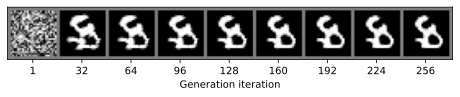

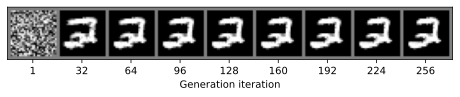

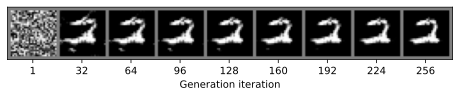

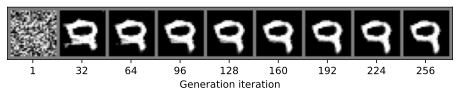

In [27]:
for i in range(imgs_per_step.shape[1]):
    step_size = callback.num_steps // callback.vis_steps
    imgs_to_plot = imgs_per_step[step_size-1::step_size,i]
    imgs_to_plot = torch.cat([imgs_per_step[0:1,i],imgs_to_plot], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.xticks([(imgs_per_step.shape[-1]+2)*(0.5+j) for j in range(callback.vis_steps+1)],
               labels=[1] + list(range(step_size,imgs_per_step.shape[0]+1,step_size)))
    plt.yticks([])
    plt.show()

## Out of Distribution Detection

In [28]:
with torch.no_grad():
    rand_imgs = torch.rand((128,) + model.hparams.img_shape).to(model.device)
    rand_imgs = rand_imgs * 2 - 1.0
    rand_out = model.cnn(rand_imgs).mean()
    print(f"Average score for random images: {rand_out.item():4.2f}")

Average score for random images: -16.27


In [29]:
with torch.no_grad():
    train_imgs,_ = next(iter(train_loader))
    train_imgs = train_imgs.to(model.device)
    train_out = model.cnn(train_imgs).mean()
    print(f"Average score for training images: {train_out.item():4.2f}")

Average score for training images: -0.01


In [30]:

@torch.no_grad()
def compare_images(img1, img2):
    imgs = torch.stack([img1, img2], dim=0).to(model.device)
    score1, score2 = model.cnn(imgs).cpu().chunk(2, dim=0)
    grid = torchvision.utils.make_grid([img1.cpu(), img2.cpu()], nrow=2, normalize=True, range=(-1,1), pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,4))
    plt.imshow(grid)
    plt.xticks([(img1.shape[2]+2)*(0.5+j) for j in range(2)],
               labels=["Original image", "Transformed image"])
    plt.yticks([])
    plt.show()
    print(f"Score original image: {score1.item():4.2f}")
    print(f"Score transformed image: {score2.item():4.2f}")

In [31]:
test_imgs, _ = next(iter(test_loader))
exmp_img = test_imgs[0].to(model.device)

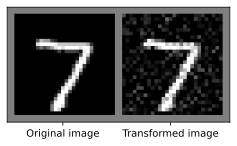

Score original image: 0.04
Score transformed image: -0.06


In [33]:
img_noisy = exmp_img + torch.randn_like(exmp_img) * 0.3
img_noisy.clamp_(min=-1.0, max=1.0)
compare_images(exmp_img, img_noisy)

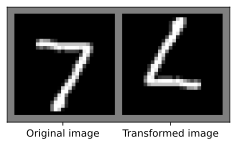

Score original image: 0.04
Score transformed image: -0.02


In [34]:
img_flipped = exmp_img.flip(dims=(1,2))
compare_images(exmp_img, img_flipped)

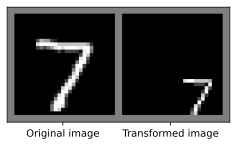

Score original image: 0.04
Score transformed image: -0.04


In [35]:
img_tiny = torch.zeros_like(exmp_img)-1
img_tiny[:,exmp_img.shape[1]//2:,exmp_img.shape[2]//2:] = exmp_img[:,::2,::2]
compare_images(exmp_img, img_tiny)